In [7]:
import pandas as pd
import yaml
root_path = '/local/work/merengelke/aipal/'
config = yaml.load(open('cfg.yaml', 'r'), Loader=yaml.FullLoader)

cities_countries = config['cities_countries']
paths = [f"{root_path}{city_country}/aipal/predict.csv" for city_country in cities_countries]

df = pd.DataFrame()
for path in paths:
    df_small = pd.read_csv(path)
    df_small['city_country'] = path.split('/')[-3]
    df = pd.concat([df, df_small])
    
# age over 18
if config['is_adult']:
    df = df[df['age'] > 18]
else:
    df = df[df['age'] <= 18]
df.drop(columns=['ELN', 'Diagnosis', 'additional.diagnosis.details..lineage.etc', 'lineage.details'], inplace=True)
features = config['feature_columns']

# remove all empty chars form class
df['class'] = df['class'].str.strip()

In [8]:
cutoffs = {
    "ALL": 0.4528432,
    "AML": 0.5001304,
    "APL": 0.3770665
}

# Define the prediction columns
prediction_columns = [f"prediction.{cat}" for cat in ["ALL", "AML", "APL"]]

# Calculate the max prediction value and corresponding class
df["max_pred_value"] = df[prediction_columns].max(axis=1)
df["max_pred_class"] = df[prediction_columns].idxmax(axis=1).str.replace("prediction.", "", regex=False)

# Check if the max prediction value is above the cutoff for the corresponding class
df["above_cutoff"] = df.apply(
    lambda row: row["max_pred_value"] >= cutoffs[row["max_pred_class"]],
    axis=1
)

# Count the number of deleted samples
deleted_count = len(df[~df["above_cutoff"]])

# Filter the DataFrame to keep only the samples above the cutoff
df = df[df["above_cutoff"]]

# Clean up temporary columns
df.drop(columns=["max_pred_value", "max_pred_class", "above_cutoff"], inplace=True)

In [9]:
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import classification_report, confusion_matrix

df.columns

y_true = df['class']
y_pred = df[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1]) 
f1_score(y_true, y_pred, average='weighted')
print(classification_report(y_true, y_pred, target_names=['ALL', 'AML', 'APL']))
print(confusion_matrix(y_true, y_pred))


              precision    recall  f1-score   support

         ALL       0.45      0.48      0.46       532
         AML       0.84      0.86      0.85      2423
         APL       0.70      0.53      0.60       395

    accuracy                           0.76      3350
   macro avg       0.66      0.62      0.64      3350
weighted avg       0.76      0.76      0.76      3350

[[ 254  248   30]
 [ 269 2093   61]
 [  39  146  210]]


Classification Report for Outlier Detection:
              precision    recall  f1-score   support

         ALL       0.46      0.53      0.49       445
         AML       0.86      0.86      0.86      2170
         APL       0.72      0.59      0.65       349

    accuracy                           0.78      2964
   macro avg       0.68      0.66      0.67      2964
weighted avg       0.79      0.78      0.78      2964

Confusion Matrix:
[[ 234  184   27]
 [ 242 1873   55]
 [  28  115  206]]


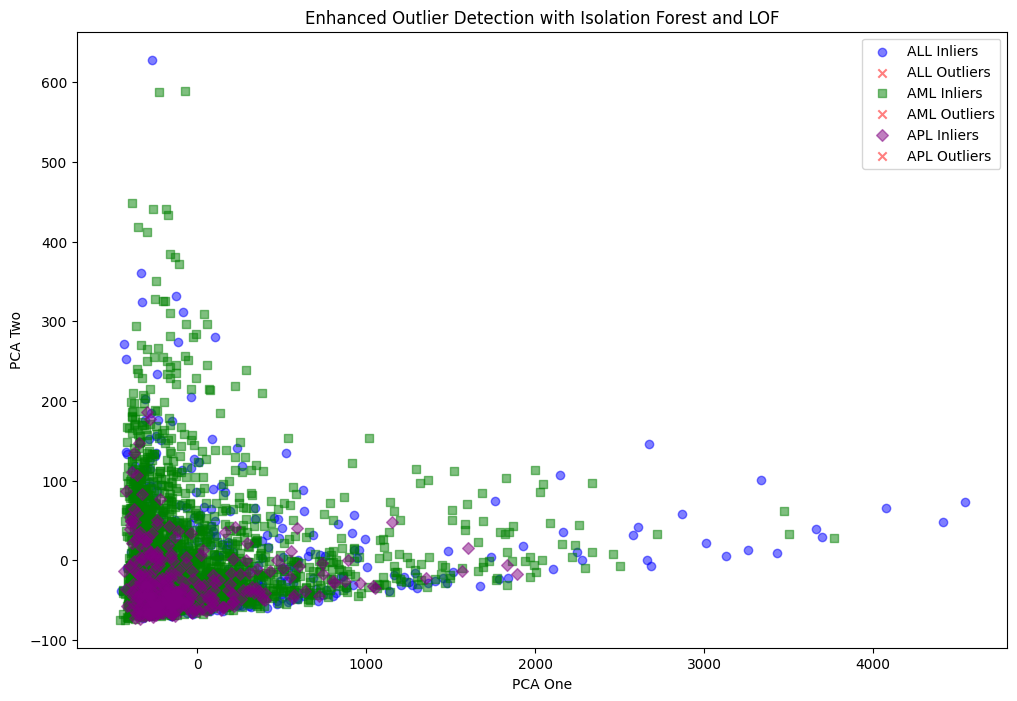

In [10]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# Load your data
data = df.copy()

# Define features and handle missing values with imputation
features = ["age", "MCV_fL", "PT_percent", "LDH_UI_L", "MCHC_g_L", 
            "WBC_G_L", "Fibrinogen_g_L", "Monocytes_G_L", 
            "Platelets_G_L", "Lymphocytes_G_L", "Monocytes_percent"]

# Impute missing values (e.g., using median for each feature)
imputer = SimpleImputer(strategy="median")
data_cleaned = data.copy()
data_cleaned[features] = imputer.fit_transform(data[features])

# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data_cleaned['outlier_iso'] = iso_forest.fit_predict(data_cleaned[features])

# Apply Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20)
data_cleaned['outlier_lof'] = lof.fit_predict(data_cleaned[features])

# Combine the outlier detections
data_cleaned['outlier'] = ((data_cleaned['outlier_iso'] == -1) | (data_cleaned['outlier_lof'] == -1)).astype(int)

# Known labels
data_cleaned = data_cleaned[data_cleaned['outlier'] == 0]
y_true = data_cleaned['class']
y_pred = data_cleaned[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1])

# Evaluation
print("Classification Report for Outlier Detection:")
print(classification_report(y_true, y_pred, target_names=['ALL', 'AML', 'APL']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_cleaned[features])
data_cleaned['pca_one'] = pca_result[:, 0]
data_cleaned['pca_two'] = pca_result[:, 1]

# Plot the results with labels
plt.figure(figsize=(12, 8))

# Plot each class with distinct colors for outliers and inliers
for class_label, color, marker in zip(['ALL', 'AML', 'APL'], ['blue', 'green', 'purple'], ['o', 's', 'D']):
    subset = data_cleaned[data_cleaned['class'] == class_label]
    # Inliers
    plt.scatter(subset.loc[subset['outlier'] == 0, 'pca_one'], 
                subset.loc[subset['outlier'] == 0, 'pca_two'], 
                color=color, marker=marker, label=f'{class_label} Inliers', alpha=0.5)
    # Outliers
    plt.scatter(subset.loc[subset['outlier'] == 1, 'pca_one'], 
                subset.loc[subset['outlier'] == 1, 'pca_two'], 
                color='red', marker='x', label=f'{class_label} Outliers', alpha=0.5)

plt.title('Enhanced Outlier Detection with Isolation Forest and LOF')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.legend()
plt.show()

Classification Report for Outlier Detection:
              precision    recall  f1-score   support

         ALL       0.47      0.50      0.49       484
         AML       0.85      0.86      0.86      2241
         APL       0.70      0.57      0.63       361

    accuracy                           0.77      3086
   macro avg       0.67      0.64      0.66      3086
weighted avg       0.77      0.77      0.77      3086

Confusion Matrix:
[[ 243  212   29]
 [ 245 1938   58]
 [  30  127  204]]


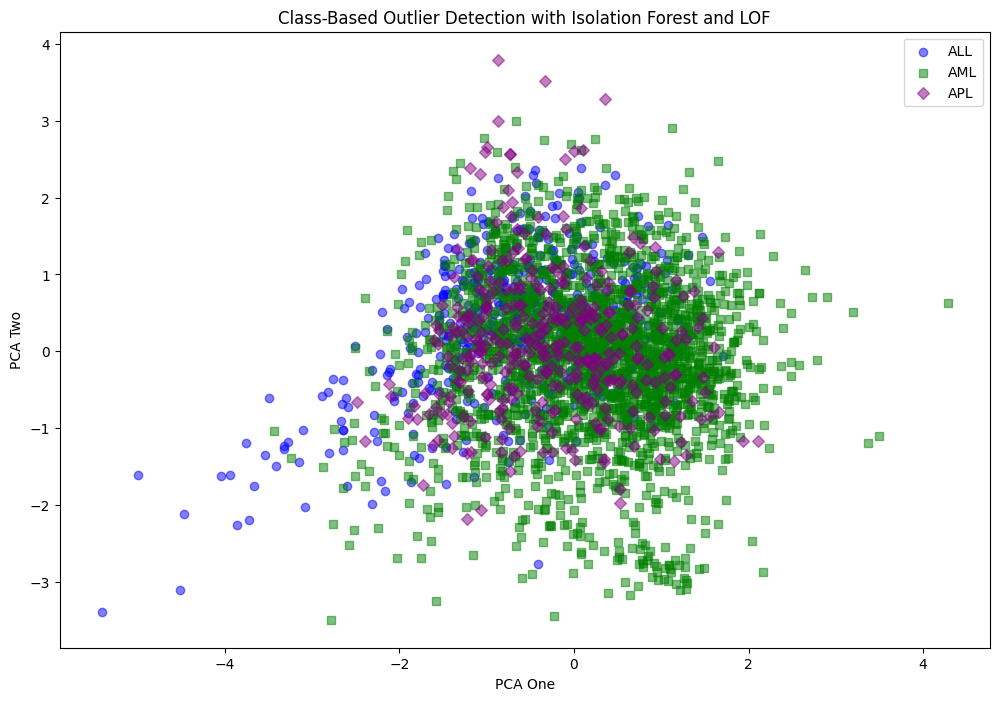

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Load your data
data = df.copy()

# Reset the index to ensure there are no duplicate labels
data = data.reset_index(drop=True)

# Define features and handle missing values with imputation
features = ["age", "MCV_fL", "PT_percent", "LDH_UI_L", "MCHC_g_L", 
            "WBC_G_L", "Fibrinogen_g_L", "Monocytes_G_L", 
            "Platelets_G_L", "Lymphocytes_G_L", "Monocytes_percent"]

# Impute missing values (e.g., using median for each feature)
imputer = SimpleImputer(strategy="median")
data_cleaned = data.copy()
data_cleaned[features] = imputer.fit_transform(data[features])

# Standardize features
scaler = StandardScaler()
data_cleaned[features] = scaler.fit_transform(data_cleaned[features])

# Apply Isolation Forest and Local Outlier Factor per class
outliers = pd.Series([0] * len(data_cleaned), index=data_cleaned.index)
for class_label in data_cleaned['class'].unique():
    # Select data for the current class and preserve the original index
    class_data = data_cleaned[data_cleaned['class'] == class_label]
    original_index = class_data.index  # Keep the index for alignment

    # Isolation Forest
    iso_forest = IsolationForest(contamination=0.05, random_state=42)
    iso_outliers = iso_forest.fit_predict(class_data[features])

    # Local Outlier Factor
    lof = LocalOutlierFactor(n_neighbors=20)
    lof_outliers = lof.fit_predict(class_data[features])

    # Combine the outlier detections within each class
    combined_outliers = pd.Series(
        ((iso_outliers == -1) | (lof_outliers == -1)).astype(int),
        index=original_index  # Ensure index alignment
    )
    
    # Assign outliers to the main Series using aligned indices
    outliers.loc[original_index] = combined_outliers

# Remove detected outliers and reset the index
data_cleaned['outlier'] = outliers
data_cleaned = data_cleaned[data_cleaned['outlier'] == 0].reset_index(drop=True)

# Known labels and predictions
y_true = data_cleaned['class']
y_pred = data_cleaned[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1])

# Evaluate performance
print("Classification Report for Outlier Detection:")
print(classification_report(y_true, y_pred, target_names=['ALL', 'AML', 'APL']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_cleaned[features])
data_cleaned['pca_one'] = pca_result[:, 0]
data_cleaned['pca_two'] = pca_result[:, 1]

# Plot the results with class-based inliers and outliers
plt.figure(figsize=(12, 8))
for class_label, color, marker in zip(['ALL', 'AML', 'APL'], ['blue', 'green', 'purple'], ['o', 's', 'D']):
    subset = data_cleaned[data_cleaned['class'] == class_label]
    plt.scatter(subset['pca_one'], 
                subset['pca_two'], 
                color=color, marker=marker, label=f'{class_label}', alpha=0.5)

plt.title('Class-Based Outlier Detection with Isolation Forest and LOF')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.legend()
plt.show()

Best Parameters for Isolation Forest:
{'contamination': 0.05, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42}
Best Parameters for Local Outlier Factor:
{'contamination': 0.05, 'n_neighbors': 10}
Classification Report for Outlier Detection:
              precision    recall  f1-score   support

         ALL       0.47      0.50      0.49       484
         AML       0.85      0.86      0.86      2241
         APL       0.70      0.57      0.63       361

    accuracy                           0.77      3086
   macro avg       0.67      0.64      0.66      3086
weighted avg       0.77      0.77      0.77      3086

Confusion Matrix:
[[ 243  212   29]
 [ 245 1938   58]
 [  30  127  204]]


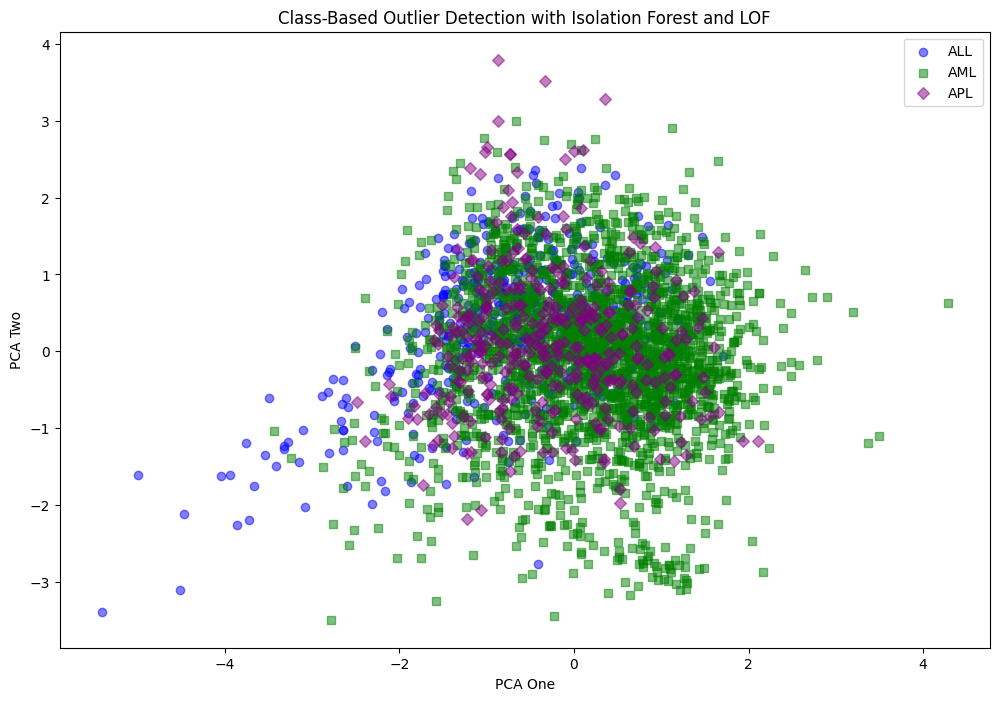

In [12]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, ParameterGrid  # Added ParameterGrid
from sklearn.metrics import make_scorer, accuracy_score

# Define feature set and target variable
X = data_cleaned[features]
y_true = (data_cleaned['outlier'] == 1).astype(int)  # Assuming we know outliers

# Define a custom scoring function for outlier detection if known labels are available
def outlier_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

outlier_scorer = make_scorer(outlier_score)

# Grid Search for Isolation Forest
param_grid_iso = {
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.8],
    'contamination': [0.05, 0.1, 0.15],
    'random_state': [42]
}

grid_search_iso = GridSearchCV(IsolationForest(), param_grid_iso, cv=5, scoring=outlier_scorer)
grid_search_iso.fit(X, y_true)
best_iso_forest = grid_search_iso.best_estimator_

print("Best Parameters for Isolation Forest:")
print(grid_search_iso.best_params_)

# Grid Search for Local Outlier Factor (LOF)
param_grid_lof = {
    'n_neighbors': [10, 20, 30],
    'contamination': [0.05, 0.1, 0.15]
}

# Since LOF doesn't have a `predict` method compatible with `GridSearchCV`, we use a workaround:
best_score = -np.inf
best_params_lof = None

for params in ParameterGrid(param_grid_lof):
    lof = LocalOutlierFactor(n_neighbors=params['n_neighbors'], contamination=params['contamination'])
    y_pred_lof = lof.fit_predict(X)
    y_pred_lof = (y_pred_lof == -1).astype(int)  # Convert -1 (outlier) and 1 (inlier) to binary format
    
    # Calculate the outlier score using accuracy_score
    score = outlier_score(y_true, y_pred_lof)
    
    if score > best_score:
        best_score = score
        best_params_lof = params

print("Best Parameters for Local Outlier Factor:")
print(best_params_lof)

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming the y_true and y_pred for the classes are available from previous steps
# Here y_true represents the actual labels, and y_pred contains predicted class based on the max score

# Known labels and predictions (already provided in your setup)
y_true = data_cleaned['class']
y_pred = data_cleaned[['prediction.ALL', 'prediction.AML', 'prediction.APL']].idxmax(axis=1).apply(lambda x: x.split('.')[1])

# Evaluate performance
print("Classification Report for Outlier Detection:")
print(classification_report(y_true, y_pred, target_names=['ALL', 'AML', 'APL']))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_cleaned[features])
data_cleaned['pca_one'] = pca_result[:, 0]
data_cleaned['pca_two'] = pca_result[:, 1]

# Plot the results with class-based inliers and outliers
plt.figure(figsize=(12, 8))
for class_label, color, marker in zip(['ALL', 'AML', 'APL'], ['blue', 'green', 'purple'], ['o', 's', 'D']):
    subset = data_cleaned[data_cleaned['class'] == class_label]
    plt.scatter(subset['pca_one'], 
                subset['pca_two'], 
                color=color, marker=marker, label=f'{class_label}', alpha=0.5)

plt.title('Class-Based Outlier Detection with Isolation Forest and LOF')
plt.xlabel('PCA One')
plt.ylabel('PCA Two')
plt.legend()
plt.show()